In [1]:
from dask.distributed import Client
client = Client("tcp://127.0.0.1:43013") # click +new from the "stack" botton
client.ncores
client.restart()

In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import glob
import copy
from pathlib import Path
import dask 
from os.path import join,expanduser
import sys
import time as time

# identify user's home directory
user_home_dir = expanduser('~')

# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco

notebook_path = os.getcwd()

# Get tracer "weights" -> time-mean T, U, and V fields

In [5]:
## Load the previously calculated weights
u_mean = xr.open_dataset('./data/UVEL_TimeMean_4mask.nc')['UVEL']
v_mean = xr.open_dataset('./data/VVEL_TimeMean_4mask.nc')['VVEL']
t_mean = xr.open_dataset('./data/THETA_TimeMean_4mask.nc')['THETA']

### Run the following if you don't have the datasets yet

In [ ]:
## Load ECCO variables
# local path to monthly-mean native grid datasets
ecco_v4r5_mon_mean_native_dir = Path('/efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/')
ecco_v4r5_mon_mean_native_dataset_paths = np.sort(list(ecco_v4r5_mon_mean_native_dir.glob('*')))

# Select dataset 1 (the one containing velocity)
dataset_num = 21 
UV_dataset_dir = ecco_v4r5_mon_mean_native_dataset_paths[dataset_num]
UV_dataset_files = np.sort(list(UV_dataset_dir.glob('*nc')))

# Select dataset 2 (the one containing temperature)
dataset_num = 20
T_dataset_dir = ecco_v4r5_mon_mean_native_dataset_paths[dataset_num]
T_dataset_files = np.sort(list(T_dataset_dir.glob('*nc')))

ecco_vars_uv = xr.open_mfdataset(UV_dataset_files, 
                                 parallel=True, data_vars='minimal',\
                                 coords='minimal',compat='override',
                                 combine='nested', concat_dim='time',
                                 chunks={'time':12, 'tile':13,' k':50,'j':90,'i':90})
ecco_vars_t = xr.open_mfdataset(T_dataset_files, 
                                parallel=True, data_vars='minimal',\
                                coords='minimal',compat='override',
                                combine='nested', concat_dim='time',
                                chunks={'time':12, 'tile':13,' k':50,'j':90,'i':90})

ds = xr.merge((ecco_vars_uv[['UVEL','VVEL']],ecco_vars_t[['THETA']]))

temp = ds['UVEL'].mean('time').rename({'i_g':'i'})
temp.to_netcdf('./data/UVEL_TimeMean_4mask.nc')

temp = ds['VVEL'].mean('time').rename({'j_g':'j'})
temp.to_netcdf('./data/VVEL_TimeMean_4mask.nc')

temp = ds['THETA'].mean('time')
temp.to_netcdf('./data/THETA_TimeMean_4mask.nc')

# Get area-weighted spatial masks for 30N in the Atlantic Basin

In [123]:
## Create along the Great Circle between 30N, -9E and 30N -97E
## then read in the file
mask_dir = './mask/'
mask_w = ecco.read_llc_to_tiles(mask_dir, "mask3d_w.-97.0_-9.0_30.0_30.0_0.0_1000.0", nk=-1) # for u field
mask_s = ecco.read_llc_to_tiles(mask_dir, "mask3d_s.-97.0_-9.0_30.0_30.0_0.0_1000.0", nk=-1) # for v field

# store in xarray.DataArray format
mask_w_da = t_mean.copy() # copy the dimension info
mask_w_da[:,:,:,:] = mask_w

mask_s_da = t_mean.copy()
mask_s_da[:,:,:,:] = mask_s

load_binary_array: loading file mask/mask3d_w.-97.0_-9.0_30.0_30.0_0.0_1000.0
load_binary_array: loading all 2D records.  nk = 50
load_binary_array: data array shape  (50, 1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (50, 1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (50, 13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
load_binary_array: loading file mask/mask3d_s.-97.0_-9.0_30.0_30.0_0.0_1000.0
load_binary_array: loading all 2D records.  nk = 50
load_binary_array: data array shape  (50, 1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (50, 1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (50, 13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4


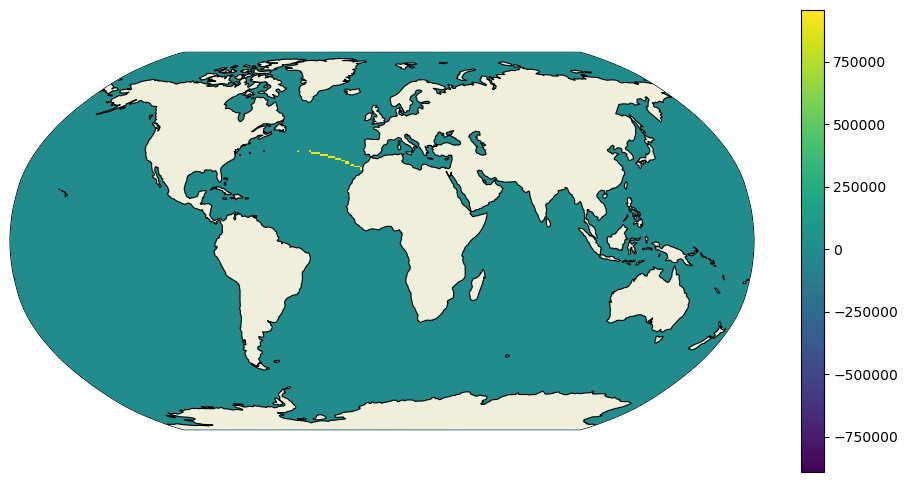

In [128]:
# Visualize the mask at surface level along the selected latitude
plt.figure(figsize=(12,6))
ecco.plot_proj_to_latlon_grid(ds_geom.XC,ds_geom.YC, mask_s_da.isel(k=0),
                              projection_type='robin',cmap='viridis',user_lon_0=0,show_colorbar=True);

# Combine masks to generate ready-to-use weight mask for U, V, and T

In [126]:
v_prime_t_bar_mask = mask_s_da * t_mean # weighted mask for v'T_bar 
u_prime_t_bar_mask = mask_w_da * t_mean # weighted mask for u'T_bar 
u_bar_t_prime_mask = mask_w_da * u_mean # weighted mask for u_bar T' 
v_bar_t_prime_mask = mask_s_da * v_mean # weighted mask for v_bar T' 

In [130]:
# Write out the mask files in binary formats
masks2write = [v_prime_t_bar_mask, u_prime_t_bar_mask, u_bar_t_prime_mask, v_bar_t_prime_mask]
fnames = ['V_prime_T_bar_Atlantic_30N_1000m_mask', 
          'U_prime_T_bar_Atlantic_30N_1000m_mask',
          'T_prime_U_bar_Atlantic_30N_1000m_mask',
          'T_prime_V_bar_Atlantic_30N_1000m_mask']

output_dir = '/efs_ecco/yfan/'
for i in range(4):
    mask_c = ecco.llc_tiles_to_compact(masks2write[i], less_output=True)
    #mask_c[~np.isfinite(mask_c)]=0.
    mask_c.astype('>f4').tofile(output_dir+fnames[i])

llc_faces_to_compact: data_compact array shape (50, 1170, 90)
llc_faces_to_compact: data_compact array shape (50, 1170, 90)
llc_faces_to_compact: data_compact array shape (50, 1170, 90)
llc_faces_to_compact: data_compact array shape (50, 1170, 90)


# Old (wrong) versions without using EMU-generated masks

### Get volume weights

In [3]:
#load dataset
geom_path = '/efs_ecco/ECCO/V4/r5/netcdf/native/geometry/GRID_GEOMETRY_ECCO_V4r5_native_llc0090.nc'
ds_geom = xr.open_dataset(geom_path)

#define dx,dy
dx = ds_geom.dxG.rename({'j_g':'j'}) 
dy = ds_geom.dyG.rename({'i_g':'i'})

#calculate volume mask
volume_mask = ds_geom['drF']*dx*dy

#depth mask
depth_mask_temp = np.where(ds_geom.Z<-1000, 0, 1)
depth_mask_da = xr.DataArray(data=depth_mask_temp, dims={"k"},coords=dict(k=ds_geom['drF'].k.values))
temp = dx.copy()-dx.values+1
depth_mask = depth_mask_da*temp

### Get geometrical mask for 30N in the Atlantic basin

In [4]:
lat = 30

maskC = ds_geom.maskC.compute()
maskS = ds_geom.maskS.compute()
maskW = ds_geom.maskW.compute()
grid = ecco.get_llc_grid(ds_geom)
ones = xr.ones_like(ds_geom.YC)
dome_maskC = ones.where(ds_geom.YC>=lat,0).compute()
lat_maskW = grid.diff(dome_maskC,'X',boundary='fill')
lat_maskS = grid.diff(dome_maskC,'Y',boundary='fill')
lat_maskC = ecco.scalar_calc.get_latitude_mask(lat,ds_geom.YC,grid)

atl_maskW = ecco.get_basin_mask(basin_name='atlExt',mask=maskW)
atl_maskS = ecco.get_basin_mask(basin_name='atlExt',mask=maskS)
atl_maskC = ecco.get_basin_mask(basin_name='atlExt',mask=maskC)

atl_30_mask_U = (lat_maskW*atl_maskW).rename({"i_g": "i"})
atl_30_mask_V = (lat_maskS*atl_maskS).rename({"j_g": "j"})
atl_30_mask_T = lat_maskC*atl_maskC
atl_30_mask_T

get_basin_name:  ['atl', 'mexico', 'hudson', 'med', 'north', 'baffin', 'gin'] /home/jovyan/ECCOv4-py/binary_data
load_binary_array: loading file /home/jovyan/ECCOv4-py/binary_data/basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
shape after reading 
(13, 90, 90)
get_basin_name:  ['atl', 'mexico', 'hudson', 'med', 'north', 'baffin', 'gin'] /home/jovyan/ECCOv4-py/binary_data
load_binary_array: loading file /home/jovyan/ECCOv4-py/binary_data/basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
shape after reading 
(13

<xarray.DataArray (tile: 13, j: 90, i: 90, k: 50)> Size: 42MB
array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
...
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]])
Coordinates:
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (tile, j, i) float32 421kB -111.6 -111.3 -110.9 ... -105.6 -111.9
    YC       (tile, j, i) float32 421kB -88.24 -88.38 -88.52 ... -88.08 -88.1
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49

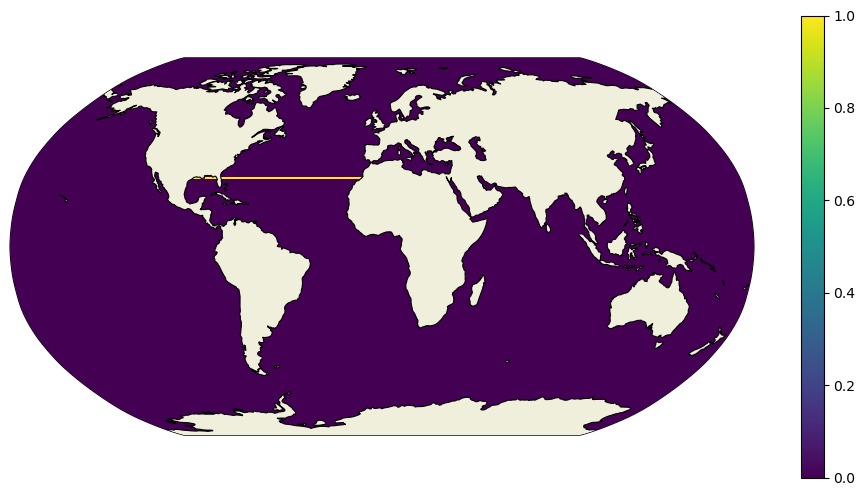

In [15]:
# Visualize the mask along the selected latitude
plt.figure(figsize=(12,6))
ecco.plot_proj_to_latlon_grid(ds_geom.XC,ds_geom.YC, atl_30_mask_T.isel(k=0),
                              projection_type='robin',cmap='viridis',user_lon_0=0,show_colorbar=True);

In [111]:
## Mask files for T' run
u_bar_weights_temp = u_mean * atl_30_mask_U * depth_mask * volume_mask
v_bar_weights_temp = v_mean * atl_30_mask_V * depth_mask * volume_mask

"""
u_bar_weights = u_bar_weights_temp.copy()
u_bar_weights[:,6:,:,:] = v_bar_weights_temp[:,6:,:,:]
v_bar_weights = v_bar_weights_temp.copy()
v_bar_weights[:,6:,:,:] = u_bar_weights_temp[:,6:,:,:]
"""

## Mask file for (U' + V') run
t_bar_weights = t_mean * atl_30_mask_T * depth_mask * volume_mask
t_bar_weights[:,:,:,:] = np.where(np.isfinite(t_bar_weights),t_bar_weights.values,0)
t_bar_weights

<xarray.DataArray (k: 50, tile: 13, j: 90, i: 90)> Size: 42MB
array([[[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
...
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]]]])
Coordinates:
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (tile, j, i) float32 421kB -111.6 -111.3 -110.9 ... -105.6 -111.9
    YC       (tile, j, i) float32 421kB -88.24 -88.38 -88.52 ... -88.08 -88.1
    Z        (k) float32 200B -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03

In [112]:
## Write out the weights into a binary file for 
mask_c = ecco.llc_tiles_to_compact(t_bar_weights, less_output=True)

# Assume you have an output directory (repalce USERNAME with your own username). If not, create one. 
# output_dir = '/efs_ecco/USERNAME/mask'
output_dir = '/efs_ecco/yfan/'
mask_fn = f'T_bar_Atlantic_30N_top1000m_weight_mask.bin'

# Output the mask
mask_c[~np.isfinite(mask_c)]=0.
mask_c.astype('>f4').tofile(output_dir+'/'+mask_fn)

llc_faces_to_compact: data_compact array shape (50, 1170, 90)


In [113]:
## read in to check
test = ecco.read_llc_to_tiles(output_dir, mask_fn, nk=-1)
test

load_binary_array: loading file /efs_ecco/yfan/T_bar_Atlantic_30N_top1000m_weight_mask.bin
load_binary_array: loading all 2D records.  nk = 50
load_binary_array: data array shape  (50, 1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (50, 1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (50, 13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4


array([[[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        ...,

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.

In [114]:
orig_tmp =  np.copy(t_bar_weights.values)
orig_tmp[~np.isfinite(orig_tmp)]=0.
print(abs(orig_tmp - test).max())
print(np.max(np.abs(test)))

524107.375
11271315000000.0


In [7]:
# Write out the weights
#u_bar_weights.to_netcdf('./data/U_bar_Atlantic_30N_top1000m_weight_mask.nc')
#v_bar_weights.to_netcdf('./data/V_bar_Atlantic_30N_top1000m_weight_mask.nc')
#t_bar_weights.to_netcdf('./data/T_bar_Atlantic_30N_top1000m_weight_mask.nc')

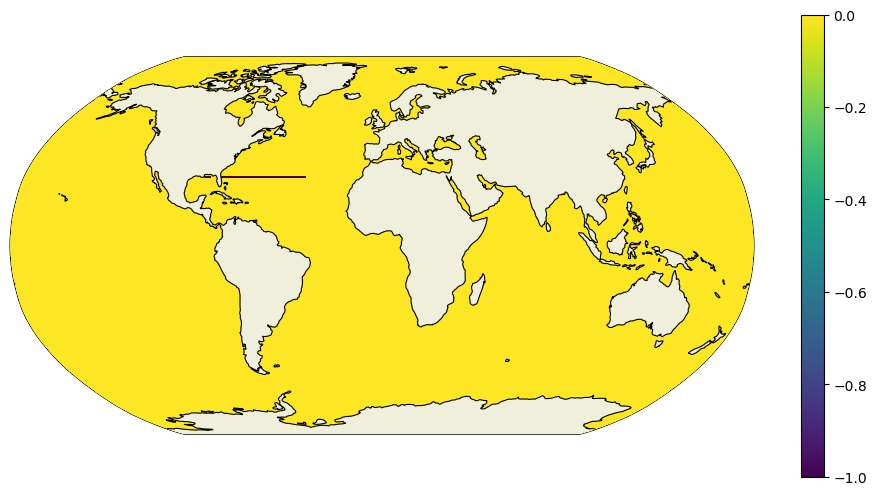

In [125]:
plt.figure(figsize=(12,6))
ecco.plot_proj_to_latlon_grid(ds_geom.XC,ds_geom.YC, atl_30_mask_U.isel(k=0),
                              projection_type='robin',cmap='viridis',user_lon_0=0,show_colorbar=True);